In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import chain, combinations
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from itertools import permutations
from evaluate import evaluate_clustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Load data
dataframe = pd.read_excel('training_set.xlsx')
print("Column names:", list(dataframe.columns))

# Validate required columns
required_columns = ['Gender', 'Grade', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Programme']
if not all(col in dataframe.columns for col in required_columns):
    print("Error: Missing required columns. Expected:", required_columns)
    raise ValueError("Missing columns")

# Extract features
raw_feature = dataframe[required_columns]

Column names: ['Programme', 'Gender', 'Grade', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']


In [4]:
# Calculate means for Q1-Q5 and total score for each programme (1,2,3,4)
programme_means = dataframe[dataframe['Programme'].isin([1, 2, 3, 4])]\
    .groupby('Programme')[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]\
    .mean()

# Calculate total score mean (Q1-Q5 sum) for each programme
programme_means['Total_Score'] = programme_means[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].sum(axis=1)

# Display results
print("\nAverage scores for each Programme (Q1-Q5 and Total Score):")
print(programme_means)

# Calculate variances for Q1-Q5 for each programme (1,2,3,4)
programme_variances = dataframe[dataframe['Programme'].isin([1, 2, 3, 4])]\
    .groupby('Programme')[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]\
    .var()

# Calculate total score variance (Q1-Q5 sum) for each programme
dataframe['Total_Score'] = dataframe[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].sum(axis=1)
total_score_variance = dataframe[dataframe['Programme'].isin([1, 2, 3, 4])]\
    .groupby('Programme')['Total_Score']\
    .var()\
    .to_frame()

# Combine variances into one dataframe
programme_variances['Total_Score'] = total_score_variance['Total_Score']

# Display results
print("\nVariances for each Programme (Q1-Q5 and Total Score):")
print(programme_variances)


Average scores for each Programme (Q1-Q5 and Total Score):
                 Q1        Q2         Q3        Q4        Q5  Total_Score
Programme                                                                
1          7.291005  4.952381  12.142857  7.272487  1.698413    33.357143
2          6.090909  2.590909   9.579545  4.829545  0.795455    23.886364
3          6.384615  3.846154  11.269231  7.423077  1.615385    30.538462
4          6.202454  3.202454   9.656442  4.328221  0.754601    24.144172

Variances for each Programme (Q1-Q5 and Total Score):
                 Q1        Q2         Q3         Q4        Q5  Total_Score
Programme                                                                 
1          2.154227  4.322188  11.208207   8.676686  2.158561    53.633739
2          6.888192  4.980146  18.200496  13.867163  2.072623    78.768548
3          6.726154  5.415385  19.804615   9.933846  3.206154   100.818462
4          5.767401  5.705673  18.745437  13.905495  1.408544    9

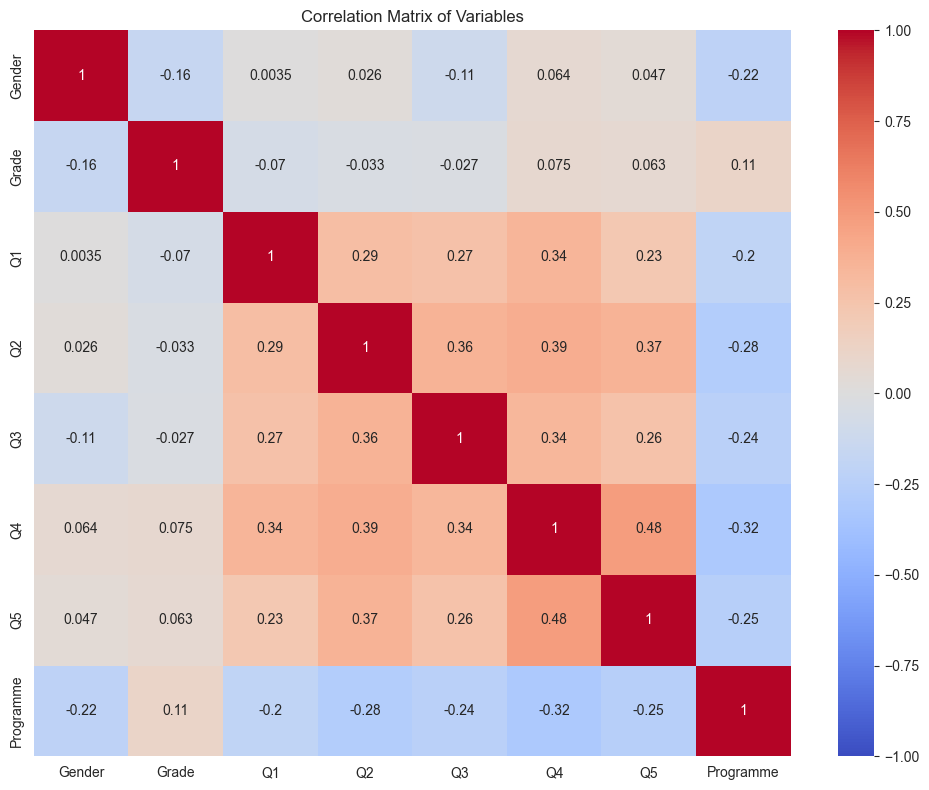

In [5]:
# Select relevant columns for correlation
columns = ['Gender', 'Grade', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Programme']
data_subset = dataframe[columns]

# Calculate correlation matrix
correlation_matrix = data_subset.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Variables')
plt.tight_layout()
plt.savefig('correlation_matrix.png')


Correlation of each subset (combined as mean) with Programme (sorted by absolute value):
Subset: Gender, Q1, Q2, Q3, Q4, Q5, Correlation: -0.3862
Subset: Gender, Q1, Q2, Q4, Q5, Correlation: -0.3835
Subset: Gender, Q2, Q3, Q4, Q5, Correlation: -0.3834
Subset: Gender, Grade, Q1, Q2, Q3, Q4, Q5, Correlation: -0.3833
Subset: Gender, Q2, Q4, Q5, Correlation: -0.3818
Subset: Gender, Grade, Q2, Q3, Q4, Q5, Correlation: -0.3799
Subset: Gender, Grade, Q1, Q2, Q4, Q5, Correlation: -0.3793
Subset: Gender, Q1, Q2, Q3, Q4, Correlation: -0.3784
Subset: Gender, Grade, Q2, Q4, Q5, Correlation: -0.3764
Subset: Gender, Q1, Q2, Q4, Correlation: -0.3758
Subset: Q1, Q2, Q3, Q4, Q5, Correlation: -0.3758
Subset: Gender, Grade, Q1, Q2, Q3, Q4, Correlation: -0.3753
Subset: Gender, Q2, Q4, Correlation: -0.3753
Subset: Gender, Q2, Q3, Q4, Correlation: -0.3750
Subset: Grade, Q1, Q2, Q3, Q4, Q5, Correlation: -0.3728
Subset: Q2, Q3, Q4, Q5, Correlation: -0.3717
Subset: Gender, Q1, Q3, Q4, Q5, Correlation: -0.3716

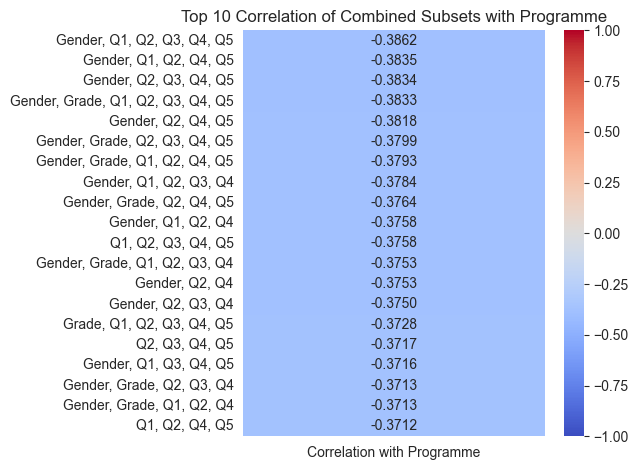

In [6]:
# Define the variables
variables = ['Gender', 'Grade', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']

# Function to generate all possible subsets
def get_subsets(iterable):
    return list(chain(*([list(combinations(iterable, i)) for i in range(1, len(iterable)+1)])))

# Get all subsets
subsets = get_subsets(variables)

# Calculate correlation for each subset by combining variables (using mean)
correlation_results = {}
for subset in subsets:
    subset = list(subset)
    # Compute the mean of the variables in the subset to represent it as a single value
    subset_mean = dataframe[subset].mean(axis=1)
    # Calculate correlation with Programme
    corr = subset_mean.corr(dataframe['Programme'])
    correlation_results[', '.join(subset)] = corr

# Convert to DataFrame and sort by absolute correlation
corr_df = pd.Series(correlation_results).to_frame(name='Correlation with Programme')
corr_df['Abs_Correlation'] = corr_df['Correlation with Programme'].abs()
corr_df = corr_df.sort_values(by='Abs_Correlation', ascending=False).drop(columns='Abs_Correlation')

# Plot correlation matrix (heatmap) for top 10 subsets
top_10_corr_df = corr_df.head(20)  # Select only the top 10 rowsplt.figure(figsize=(10, len(top_10_corr_df) * 0.3))
sns.heatmap(top_10_corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.4f')
plt.title('Top 10 Correlation of Combined Subsets with Programme')
plt.tight_layout()
plt.savefig('top_20_subset_programme_correlations.png')

# Print sorted correlations
print("\nCorrelation of each subset (combined as mean) with Programme (sorted by absolute value):")
for subset, corr in corr_df['Correlation with Programme'].items():
    print(f"Subset: {subset}, Correlation: {corr:.4f}")

In [18]:
# Extract features and true labels
scaler_minmax = MinMaxScaler()
feature_set1 = raw_feature[['Grade','Gender']].copy()
feature_set1['Q_avg'] = raw_feature[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].mean(axis=1)
X_scaled = scaler_minmax.fit_transform(feature_set1)

y_true = dataframe['Programme'].values

# Initialize clustering methods (all with 4 clusters)
clustering_methods = {
    'K-means': KMeans(n_clusters=4, init='random', n_init=10, random_state=42),
    'Hierarchical': AgglomerativeClustering(n_clusters=4, linkage='complete'),
    'Gaussian Mixture': GaussianMixture(n_components=4, covariance_type='tied', random_state=42)
}

# Store results
results = []

# Perform clustering and evaluate
for name, model in clustering_methods.items():
    # Fit model and get labels
    if name == 'Gaussian Mixture':
        labels = model.fit_predict(X_scaled)
    else:
        labels = model.fit_predict(X_scaled)

    # Compute inter/intra ratio using provided function
    ratio = evaluate_clustering(X_scaled, labels, None)

    # Compute F1-score (align clusters with true labels)
    unique_labels = np.unique(labels)
    unique_true = np.unique(y_true)
    best_f1 = 0
    if len(unique_labels) > 0 and len(unique_true) > 0:
        # Map cluster labels to true labels for best F1
        for perm in permutations(unique_true, len(unique_labels)):
            mapped_labels = labels.copy()
            for i, cluster in enumerate(unique_labels):
                mapped_labels[labels == cluster] = perm[i]
            f1 = f1_score(y_true, mapped_labels, average='weighted')
            best_f1 = max(best_f1, f1)

    # Store results
    results.append({
        'Method': name,
        'Intra/Inter Ratio': ratio,
        'F1-Score': best_f1
    })

# Print results
results_df = pd.DataFrame(results)
print("\nClustering Results:")
print(results_df)

File saved successfully in None
Intra-cluster to Inter-cluster distance ratio: 0.2652
File saved successfully in None
Intra-cluster to Inter-cluster distance ratio: 0.2087
File saved successfully in None
Intra-cluster to Inter-cluster distance ratio: 0.2648

Clustering Results:
             Method  Intra/Inter Ratio  F1-Score
0           K-means           0.265247  0.547522
1      Hierarchical           0.208723  0.452025
2  Gaussian Mixture           0.264758  0.433916


In [8]:
# Extract features (Set 3: Q1-Q5 marks) and labels
X = dataframe[['Gender', 'Grade', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']].values
y = dataframe['Programme'].values

# Compute total score (Q1 + Q2 + Q3 + Q4 + Q5) for each student
total_scores = np.sum(X, axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test, total_scores_train, total_scores_test = train_test_split(
    X_scaled, y, total_scores, test_size=0.2, random_state=42
)

# Initialize kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train model
knn.fit(X_train, y_train)

# Predict on test set
y_pred = knn.predict(X_test)

# Split predictions into Programme 1 and not Programme 1
prog1_mask = y_pred == 1  # Assuming Programme labels are 1, 2, 3, 4
not_prog1_mask = y_pred != 1

# Compute average total scores
avg_score_prog1 = np.mean(total_scores_test[prog1_mask]) if np.sum(prog1_mask) > 0 else np.nan
avg_score_not_prog1 = np.mean(total_scores_test[not_prog1_mask]) if np.sum(not_prog1_mask) > 0 else np.nan

# Store results
results = [
    {'Group': 'Predicted Programme 1', 'Average Total Score': avg_score_prog1},
    {'Group': 'Predicted Not Programme 1', 'Average Total Score': avg_score_not_prog1}
]

# Print results
results_df = pd.DataFrame(results)
print("\nAverage Total Scores (Q1 + Q2 + Q3 + Q4 + Q5):")
print(results_df)

# Save results to CSV
results_df.to_csv('knn_score_results.csv', index=False)


Average Total Scores (Q1 + Q2 + Q3 + Q4 + Q5):
                       Group  Average Total Score
0      Predicted Programme 1            37.090909
1  Predicted Not Programme 1            26.012821



Training Naive Bayes...


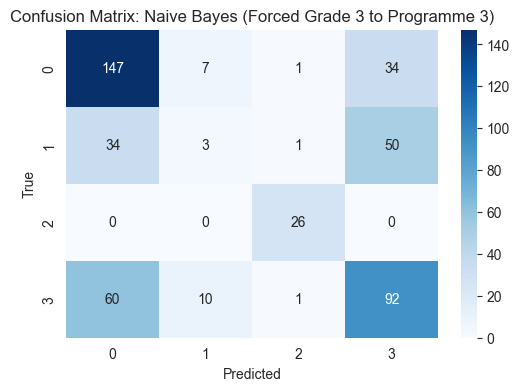


Training Decision Tree...


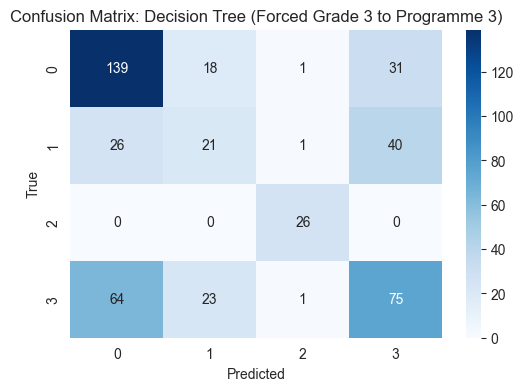


Training KNN...


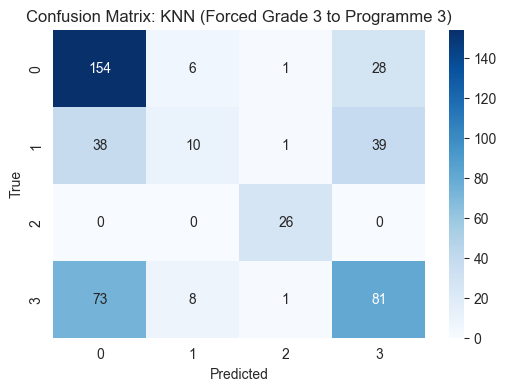


Training Voting (Soft)...


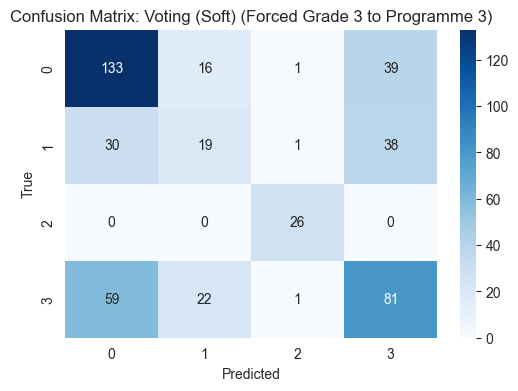


Training Voting (Hard)...


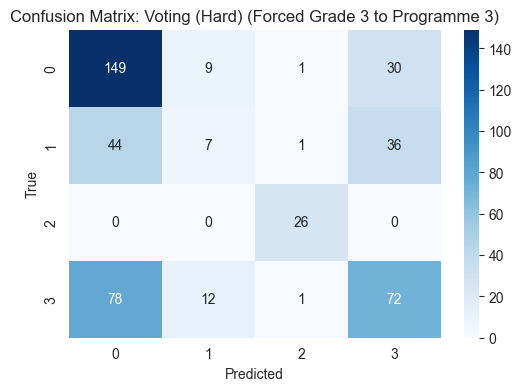


Classification Results (Original Predictions on Non-Grade 3 Samples):
      Classifier  Accuracy  F1 Score  Accuracy Std    F1 Std  \
0    Naive Bayes  0.553945  0.426667      0.066163  0.047071   
1  Decision Tree  0.537748  0.475102      0.095886  0.132624   
2            KNN  0.560684  0.459341      0.076372  0.077943   
3  Voting (Soft)  0.533281  0.470705      0.042122  0.056840   
4  Voting (Hard)  0.521813  0.416119      0.047814  0.067353   

                                Best Params  
0                  {'var_smoothing': 1e-09}  
1  {'max_depth': 5, 'min_samples_split': 2}  
2               {'n_neighbors': 15, 'p': 2}  
3                                       N/A  
4                                       N/A  

Recommended Model: KNN
Reason: Achieves highest accuracy (0.56 ± 0.08) and F1 score (0.46 ± 0.08) with parameters {'n_neighbors': 15, 'p': 2}.


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os

# Teacher-provided function to save predicted labels
def evaluate_classification(predicted_labels, filename='predicted_labels.csv'):
    """
    Save predicted labels to a specified CSV file.

    Parameters:
    predicted_labels (list): A list of predicted labels to save.
    filename (str): The name of the CSV file where the labels will be saved.
    """
    try:
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            for label in predicted_labels:
                writer.writerow([label])  # Write each label in a new row
        print(f"Predicted labels successfully saved to {filename}.")
    except Exception as e:
        print(f"An error occurred while saving labels: {e}")

# Independent function for forced classification of Grade == 3 to Programme == 3
# This function can be deleted to revert to original classifier predictions
def force_grade3_to_programme3(dataframe, X, label, y_pred_classifier, skf):
    """
    Force samples with Grade == 3 to be classified as Programme == 3.
    Remaining samples are predicted by the classifier.

    Parameters:
    dataframe (pd.DataFrame): Original dataset with 'Grade' column.
    X (pd.DataFrame): Feature matrix.
    label (pd.Series): True labels.
    y_pred_classifier (np.ndarray): Predictions from classifier for all samples.
    skf (StratifiedKFold): Cross-validation object for consistent folds.

    Returns:
    np.ndarray: Combined predictions with Grade == 3 forced to Programme == 3.
    """
    # Identify Grade == 3 samples
    grade_3_mask = dataframe['Grade'] == 3
    non_grade_3_mask = ~grade_3_mask

    # Initialize final predictions array
    y_pred_forced = np.zeros_like(label)

    # Set Grade == 3 samples to Programme == 3
    y_pred_forced[grade_3_mask] = 3

    # Use classifier predictions for non-Grade == 3 samples
    y_pred_forced[non_grade_3_mask] = y_pred_classifier[non_grade_3_mask]

    return y_pred_forced

# Check for required columns
required_columns = ['Programme', 'Gender', 'Grade', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']

# Extract features and label
label = dataframe['Programme']
features_selected = ['Gender', 'Grade', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']
f = dataframe[features_selected]

scaler_standard = StandardScaler()

X = scaler_standard.fit_transform(f)

# Define classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Voting (Soft)': VotingClassifier(estimators=[
        ('nb', GaussianNB()),
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('knn', KNeighborsClassifier())
    ], voting='soft'),
    'Voting (Hard)': VotingClassifier(estimators=[
        ('nb', GaussianNB()),
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('knn', KNeighborsClassifier())
    ], voting='hard')
}

# Parameter grids for tuning
param_grids = {
    'Naive Bayes': {'var_smoothing': [1e-9, 1e-8]},
    'Decision Tree': {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5]},
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11, 15], 'p': [1, 2]}
}

# Perform experiments
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare data for non-Grade == 3 samples
grade_3_mask = dataframe['Grade'] == 3
non_grade_3_mask = ~grade_3_mask
X_non_grade_3 = X[non_grade_3_mask]
label_non_grade_3 = label[non_grade_3_mask]

for clf_name, clf in classifiers.items():
    print(f"\nTraining {clf_name}...")
    if clf_name.startswith('Voting'):
        # Cross-validation for VotingClassifier on non-Grade == 3 samples
        scores = cross_val_score(clf, X_non_grade_3, label_non_grade_3, cv=skf, scoring='accuracy')
        f1_scores = cross_val_score(clf, X_non_grade_3, label_non_grade_3, cv=skf, scoring='f1_macro')
        y_pred_non_grade_3 = cross_val_predict(clf, X_non_grade_3, label_non_grade_3, cv=skf)

        # Create full predictions array (initialize with zeros)
        y_pred_classifier = np.zeros_like(label)
        y_pred_classifier[non_grade_3_mask] = y_pred_non_grade_3
    else:
        # Parameter tuning with GridSearchCV on non-Grade == 3 samples
        grid = GridSearchCV(clf, param_grids[clf_name], cv=skf, scoring='accuracy', n_jobs=-1)
        grid.fit(X_non_grade_3, label_non_grade_3)
        scores = cross_val_score(grid.best_estimator_, X_non_grade_3, label_non_grade_3, cv=skf, scoring='accuracy')
        f1_scores = cross_val_score(grid.best_estimator_, X_non_grade_3, label_non_grade_3, cv=skf, scoring='f1_macro')
        y_pred_non_grade_3 = cross_val_predict(grid.best_estimator_, X_non_grade_3, label_non_grade_3, cv=skf)

        # Create full predictions array
        y_pred_classifier = np.zeros_like(label)
        y_pred_classifier[non_grade_3_mask] = y_pred_non_grade_3

    # Apply forced classification for Grade == 3
    y_pred_forced = force_grade3_to_programme3(dataframe, X, label, y_pred_classifier, skf)

    # Save confusion matrix (forced)
    conf_mat = confusion_matrix(label, y_pred_forced)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {clf_name} (Forced Grade 3 to Programme 3)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # plt.savefig(f'output/{clf_name.replace(" ", "_")}_conf_matrix.png')
    plt.show()

    # Store results (based on original predictions for fair comparison)
    results.append({
        'Classifier': clf_name,
        'Accuracy': scores.mean(),
        'F1 Score': f1_scores.mean(),
        'Accuracy Std': scores.std() * 2,
        'F1 Std': f1_scores.std() * 2,
        'Best Params': grid.best_params_ if not clf_name.startswith('Voting') else 'N/A'
    })

# Generate results table
results_df = pd.DataFrame(results)
print("\nClassification Results (Original Predictions on Non-Grade 3 Samples):")
print(results_df[['Classifier', 'Accuracy', 'F1 Score', 'Accuracy Std', 'F1 Std', 'Best Params']])
results_df.to_csv('output/classification_results.csv', index=False)

# Recommendation
best_result = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nRecommended Model: {best_result['Classifier']}")
print(f"Reason: Achieves highest accuracy ({best_result['Accuracy']:.2f} ± {best_result['Accuracy Std']:.2f}) "
      f"and F1 score ({best_result['F1 Score']:.2f} ± {best_result['F1 Std']:.2f}) with parameters {best_result['Best Params']}.")